In [ ]:
import keras

Using TensorFlow backend.


In [ ]:
from keras.datasets.fashion_mnist import load_data # Load the fashion-mnist train data and test data
(x_train, y_train), (x_test, y_test) = load_data() # output


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from keras.utils import to_categorical 
encoded_y_train = to_categorical(y_train, num_classes=10, dtype='float32')
encoded_y_test = to_categorical(y_test, num_classes=10, dtype='float32')

In [ ]:
import numpy as np
%matplotlib inline
def show_images(images):
    """
    images : numpy arrays
    """
    n_images = len(images)
    titles = ['(%d)' % i for i in range(1, n_images + 1)]
    num = 5
    iter_num = np.ceil(n_images / num).astype(int)
    for i in range(iter_num):
        fig = plt.figure()
        sub_images = images[i * num:num * (i + 1)]
        sub_titles = titles[i * num:num * (i + 1)]
        for n, (image, title) in enumerate(zip(sub_images, sub_titles)):
            a = fig.add_subplot(1, np.ceil(len(sub_images)), n + 1)
            if image.ndim == 2:
                plt.gray()
            a.set_title(title, fontsize=15)
            plt.imshow(image)

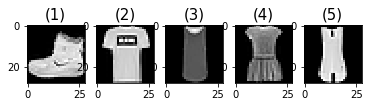

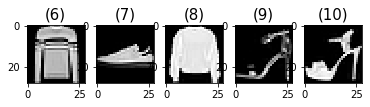

In [ ]:
show_images(x_train[:10])

In [ ]:
norm_x_train = x_train.astype('float32') / 255
norm_x_test = x_test.astype('float32') / 255

In [ ]:
from skimage.transform import resize

target_size = 96

def preprocess_image(x):
    # Resize the image to have the shape of (96,96)
    x = resize(x, (target_size, target_size),
            mode='constant',
            anti_aliasing=False)
    
    # convert to 3 channel (RGB)
    x = np.stack((x,)*3, axis=-1) 
    
    # Make sure it is a float32, here is why 
    # https://www.quora.com/When-should-I-use-tf-float32-vs-tf-float64-in-TensorFlow
    return x.astype(np.float32)

In [ ]:
from sklearn.utils import shuffle
def load_data_generator(x, y, batch_size=64):
    num_samples = x.shape[0]
    while 1:  # Loop forever so the generator never terminates
        try:
            shuffle(x)
            for i in range(0, num_samples, batch_size):
                x_data = [preprocess_image(im) for im in x[i:i+batch_size]]
                y_data = y[i:i + batch_size]
            
                # convert to numpy array since this what keras required
                yield shuffle(np.array(x_data), np.array(y_data))
        except Exception as err:
            print(err)

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Input, Dropout
from keras.models import Model

def build_model( ):
    input_tensor = Input(shape=(target_size, target_size, 3))
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        input_shape=(target_size, target_size, 3),
        pooling='avg')

    for layer in base_model.layers:
        layer.trainable = True  # trainable has to be false in order to freeze the layers
        
    op = Dense(256, activation='relu')(base_model.output)
    op = Dropout(.25)(op)
    
    ##
    # softmax: calculates a probability for every possible class.
    #
    # activation='softmax': return the highest probability;
    # for example, if 'Coat' is the highest probability then the result would be 
    # something like [0,0,0,0,1,0,0,0,0,0] with 1 in index 5 indicate 'Coat' in our case.
    ##
    output_tensor = Dense(10, activation='softmax')(op)

    model = Model(inputs=input_tensor, outputs=output_tensor)


    return model

In [ ]:
from keras.optimizers import Adam
model = build_model()
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])












9412608/9406464 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [ ]:

train_generator = load_data_generator(norm_x_train, encoded_y_train, batch_size=64)

model.fit_generator(
    generator=train_generator,
    steps_per_epoch=5,
    verbose=1,
    epochs=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
5/5 [==============================] - 16s 3s/step - loss: 1.8414 - categorical_accuracy: 0.4125
Epoch 2/2
5/5 [==============================] - 1s 224ms/step - loss: 0.8505 - categorical_accuracy: 0.7281


In [ ]:
test_generator = load_data_generator(norm_x_test, encoded_y_test, batch_size=64)
model.evaluate_generator(generator=test_generator,
                         steps=900,
                         verbose=1)

In [ ]:
model_name = "tf_serving_keras_mobilenetv2"
model.save(f"./{model_name}.h5")

In [ ]:
model_name = "keras_mobilenetv2_mnist"
model.save(f"/content/gdrive/My Drive/{model_name}.h5")